# Chapter 04 word2vec 속도 개선

1. Embedding 계층 도입

2. 네거티브 샘플링 손실 함수 도입

3. 완성된 word2vec을 통한 PTB 데이터셋에 대한 학습

4. 결과로 얻은 단어의 분산 표현의 장점 평가

## 4.1 word2vec 개선 $\mathrm{I}$

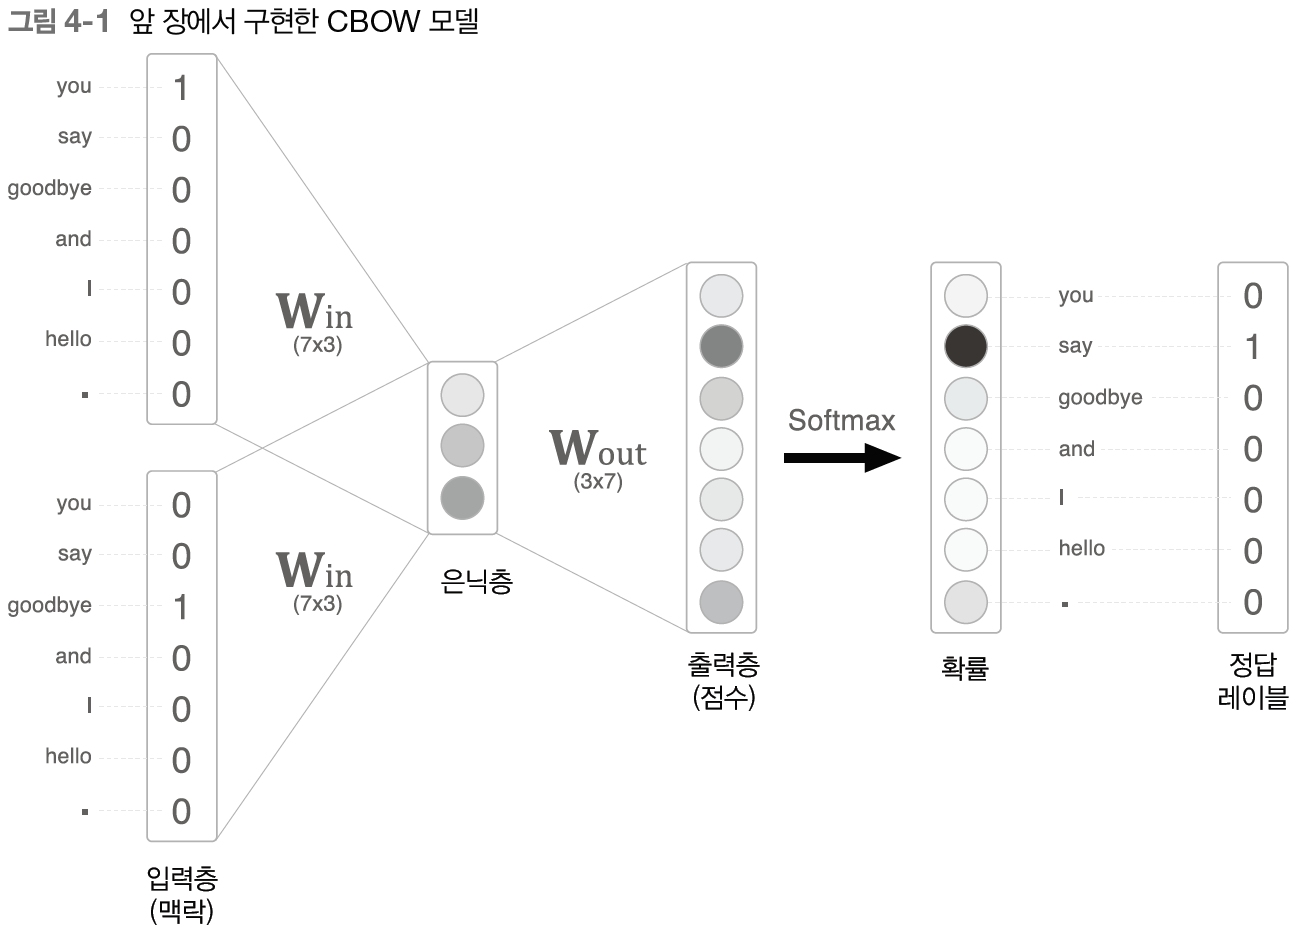

In [1]:
import os
from PIL import Image

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
img_path = os.path.join(parent_dir, 'images')

Image.open(os.path.join(img_path, 'fig 4-1.png'))

$\textbf{WARNING}$

앞 장에서는 맥락의 윈도우 크기를 1로 한정했다. 다시 말해 타깃 앞뒤 한 단어씩만 사용한 것이다. 이번 장에서는 나중에 어떤 크기의 맥락도 다룰 수 있도록 기능을 추가하고자 한다.

[그림 4-1]과 같은 CBOW 모델은 작은 말뭉치를 다룰 때는 문제될 게 없다.

그러나 거대한 말뭉치를 다루게 되는 경우 몇 가지 문제가 발생한다.

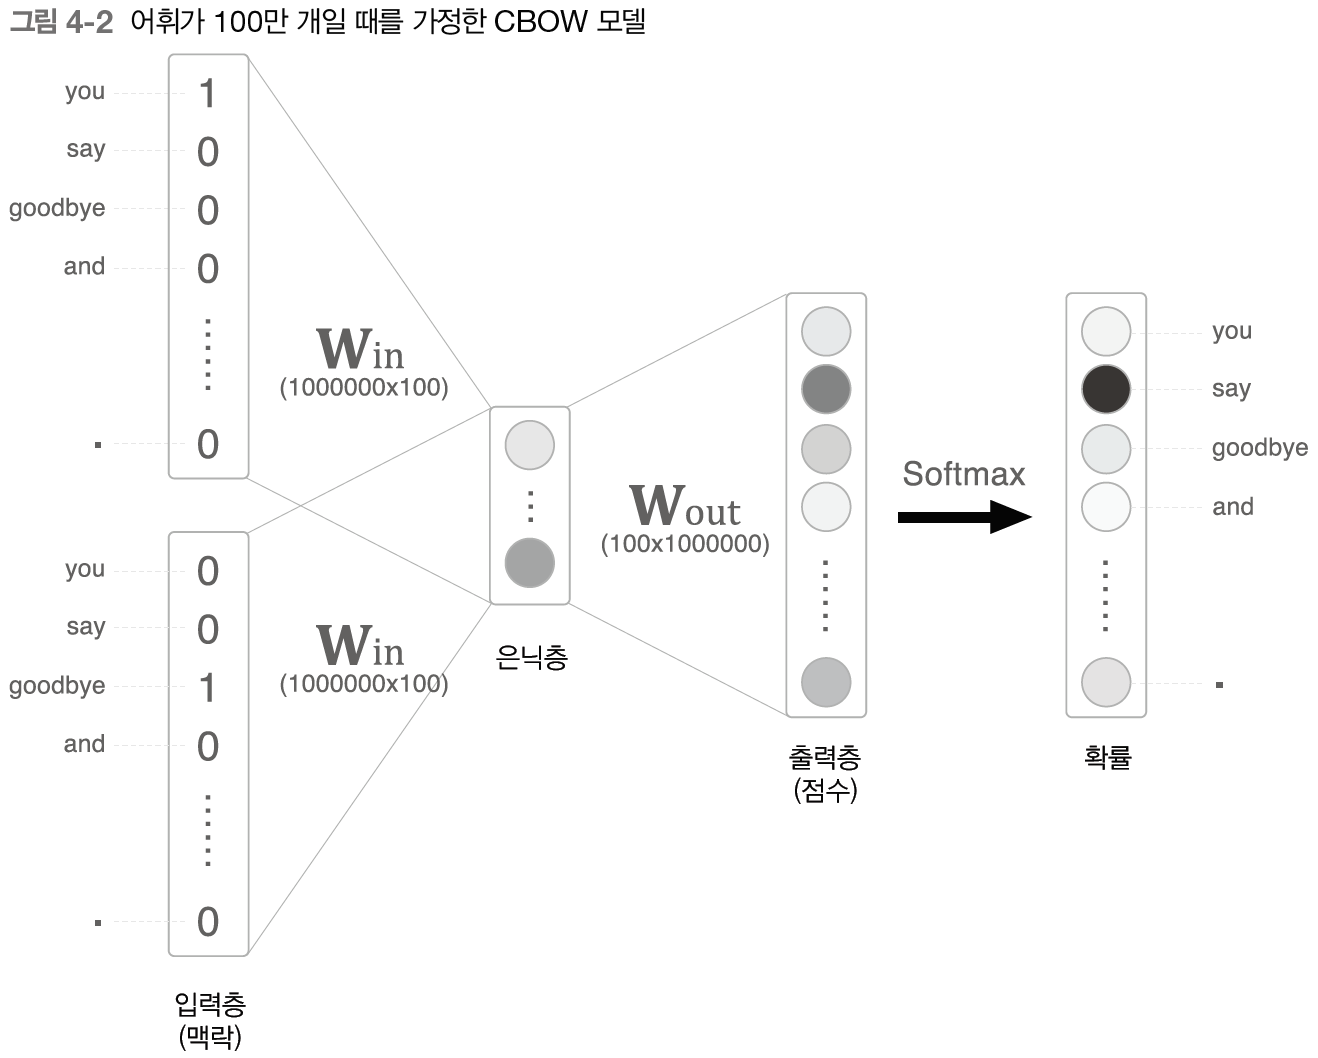

In [2]:
Image.open(os.path.join(img_path, 'fig 4-2.png'))

[그림 4-2]에서 보듯, 입력층과 출력층에는 각 100만 개의 뉴런이 존재하기에 중간 계산에 많은 시간이 소요된다.

- 입력층의 원핫 표현과 가중치 행렬 $\mathbf{W}_{\text{in}}$ 의 곱 계산
- 은닉층과 가중치 행렬 $\mathbf{W}_{\text{out}}$ 의 곱 및 Softmax 계층의 계산

첫 번째 문제는 입력층의 원핫 표현과 관련된 것이다.

단어를 원핫 표현으로 다루기 때문에 어휘 수가 많아지면 원핫 표현의 벡터 크기도 커지게 된다.

어휘가 100만 개인 경우 그 원핫 표현 하나만 해도 원소 수가 100만 개인 벡터가 된다.

게다가 이 원핫 벡터와 가중치 행렬 $\mathbf{W}_{\text{in}}$ 을 곱해야 하는데, 여기서도 많은 계산 자원이 소요된다.

이 문제는 Embedding 계층을 도입하는 것으로 해결한다.

두 번째 문제는 은닉층 이후의 계산이다.

은닉층과 가중치 행렬 $\mathbf{W}_{\text{out}}$ 의 곱만 해도 계산량이 상당하다.

그리고 Softmax 계층에서도 다루는 어휘가 많아짐에 따라 계산량이 증가하는 문제가 있다.

이 문제는 4.2절에서 네거티브 샘플링이라는 새로운 손실 함수를 도입해서 해결한다.

### 4.1.1 Embedding 계층

앞선 word2vec 구현에서 다루는 어휘 수가 100만 개, 은닉층 뉴런이 100개인 경우를 생각해본다.

이때 MatMul 계층의 행렬 곱은 다음 그림과 같다.

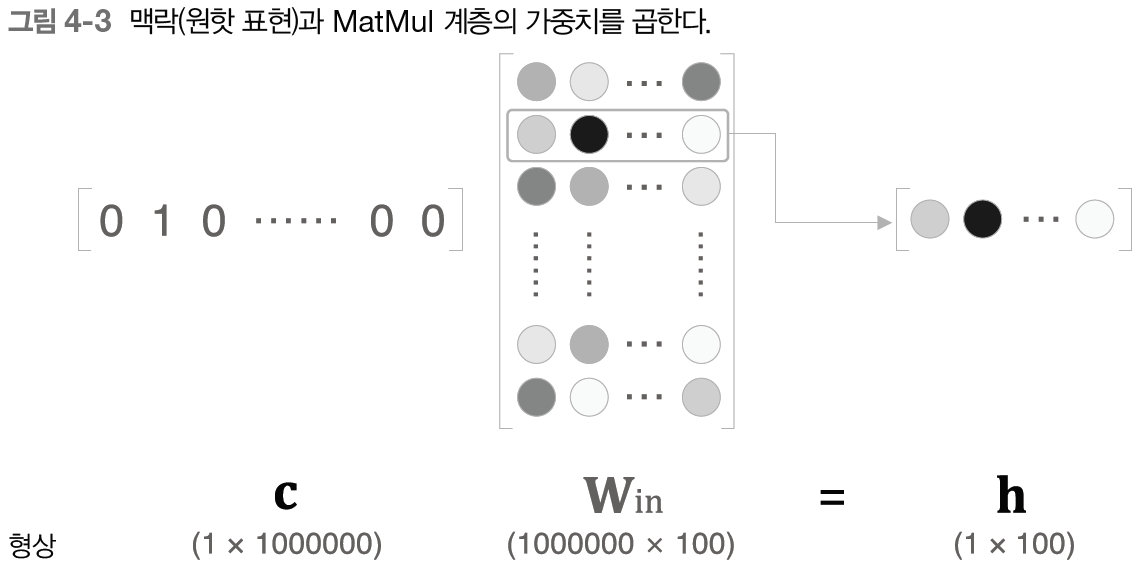

In [3]:
Image.open(os.path.join(img_path, 'fig 4-3.png'))

위와 같은 경우처럼 100만 개의 어휘를 담은 말뭉치가 있다면, 단어의 원핫 표현도 100만 차원이 된다.

그러나 결국 수행하는 일은 행렬의 특정 행을 추출하는 것이기 때문에

원핫 표현으로의 변환과 MatMul 계층의 행렬 곱 계산은 사실 필요가 없는 것이다.

그러면 가중치 매개변수로부터 '단어 ID에 해당하는 행(벡터)'을 추출하는 계층을 만들어본다.

이 계층을 Embedding 계층이라고 부른다. (Embedding이란 $\text{단어 임베딩}^{\text{word embedding}}$ 이란 용어에서 유래함)

즉, Embedding 계층에 단어 임베딩(분산 표현)을 저장하는 것이다.

### 4.1.2 Embedding 계층 구현

행렬에서 특정 행을 추출하려면 가중치 행렬 `W` 에 대해서 `W[2]` 나 `W[5]` 처럼 원하는 행을 명시하면 된다.

In [4]:
import numpy as np

W = np.arange(21).reshape(7, 3)
print(W)

print(W[2])

print(W[5])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
[6 7 8]
[15 16 17]


가중치 `W` 로부터 여러 행을 한꺼번에 추출할 수도 있다.

In [5]:
idx = np.array([1, 0, 3, 0])
print(W[idx])

[[ 3  4  5]
 [ 0  1  2]
 [ 9 10 11]
 [ 0  1  2]]


이와 같이 인수에 배열을 사용하면 여러 행도 한꺼번에 추출 가능하다. (미니배치 처리를 가정했을 경우의 구현)

Embedding 계층의 `forward()` 메서드를 구현한다 (common/layers.py)

이 책의 구현 규칙에 따라 인스턴스 변수 `params` 와 `grads` 를 사용한다.

또한 인스턴스 변수 `idx` 에는 추출하는 god의 인덱스(단어ID)를 배열로 저장한다.

Embedding 계층의 순전파는 가중치 `W` 의 특정행을 추출할 뿐이기에,

역전파에서는 앞 층(출력 측 층)으로부터 전해진 기울기를 다음 층(입력 측 층)으로 그대로 흘려주기만 하면 된다.

다만, 앞 층으로부터 전해진 기울기를 가중치 기울기 `dW` 의 특정 행(`idx` 번째 행)에 설정한다.

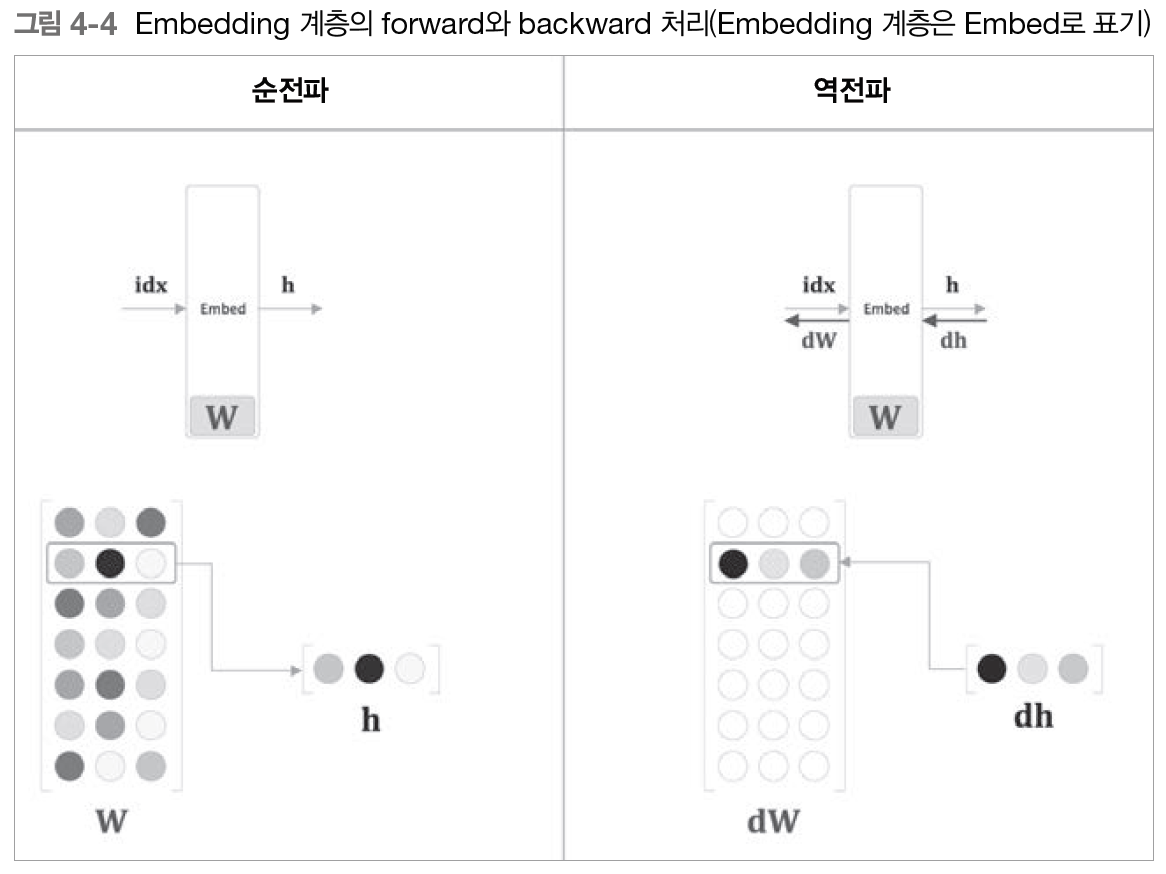

In [6]:
Image.open(os.path.join(img_path, 'fig 4-4.png'))

그러면 `backward()` 구현도 쉽게 할 수 있다.

In [7]:
def backward(self, dout):
    dw, = self.grads
    dw[...] = 0
    dw[self.idx] = dout
    return None

이 코드에서 가중치 기울기 `dw` 를 꺼낸 다음, `dw[...] = 0` 에서 `dW` 의 원소를 0으로 덮어쓴다.

단순히 `dW` 자체를 0으로 설정하는게 아니라, `dW` 의 형상을 유지한 채, 그 원소들을 0으로 덮어쓰는 것이다.

그리고 앞 층에서 전해진 기울기 `dout`을 `idx` 번째 행에 할당한다. 

$\textbf{WARNING}$

여기에서는 가중치 `W` 와 크기가 같은 행렬 `dW` 를 만들고, `dW` 의 특정 행에 기울기를 할당했다. 그러나 최종적으로 하고 싶은 일은 가중치 `W` 를 갱신하는 것이므로 일부러 `dW` 와 같은 (`W` 와 같은 크기의) 행렬을 만들 필요는 없다. 이렇게 하지 않고, 갱신하려는 행 번호(`idx`) 와 그 기울기 (`dout`) 를 따로 저장해두면, 이 정보로부터 가중치 `W` 의 특정 행만 갱신할 수 있다. 다만 여기서는 이미 구현해둔 갱신용 클래스(Optimizer)와 조합해서 사용하는 것을 고려해 지금처럼 구현하였다.

그러나 이러한 `backward()` 구현에는 문제가 하나 있다.

`idx` 의 원소가 중복되는 경우, 예를 들어 `idx = [0, 2, 0, 4]` 인 경우 다음 그림과 같은 문제가 발생한다.

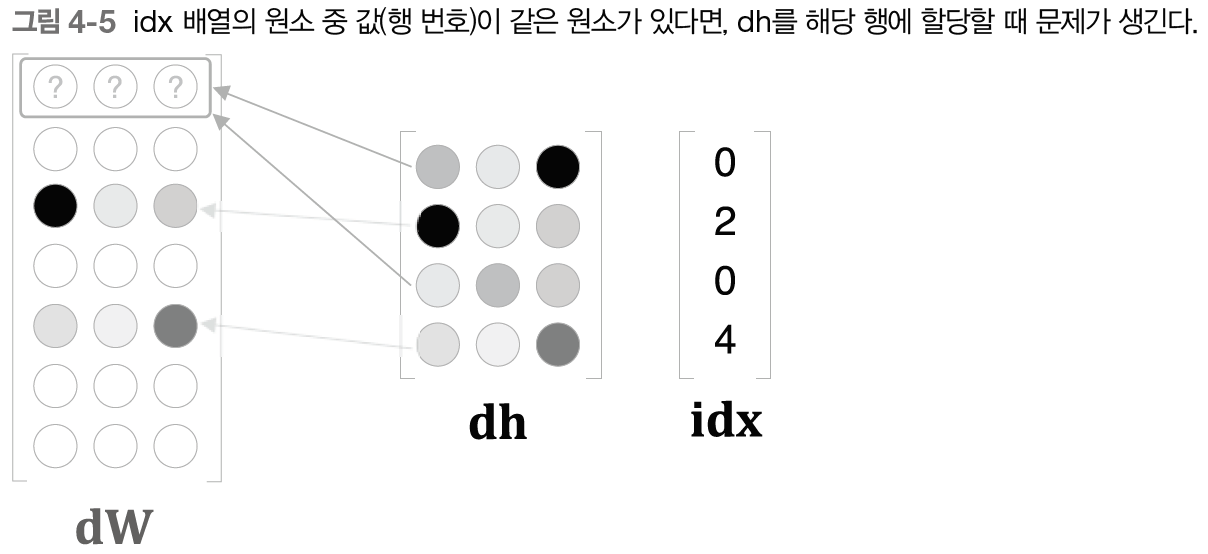

In [8]:
Image.open(os.path.join(img_path, 'fig 4-5.png'))

이 경우 `dW` 의 0번째 행에 2개의 값이 할당되고, 먼저 쓰여진 값이 덮어씌여지는 문제가 발생한다.

이 중복 문제를 해결하려면 '할당'이 아닌 '더하기'를 해야 한다.

즉, `dh` 의 각 행의 값을 `dW` 의 해당 행에 더해준다.

In [9]:
def backward(self, dout):
    dW, = self.grads
    dW[...] = 0

    for i, word_id in enumerate(self.idx):
        dW[word_id] += dout[i]
    # 혹은
    # np.add.at(dW, self.idx, dout)

    return None

여기에서는 `for` 문을 사용해서 해당 인덱스에 기울기를 더한다.

이것으로 `idx` 에 중복 인덱스 문제가 해결된다.

참고로, `for` 문 대신 넘파이의 `np.add.at()` 을 사용해도 된다.

`np.add.at(A, idx, B)` 는 `B` 를 `A` 의 idx 번째 행에 더해준다.

$\textbf{NOTE}$

일반적으로 파이썬에서 `for` 문보다는 넘파이의 내장 메서드를 사용하는 편이 더 빠르다. 넘파이의 메서드에는 속도와 효율을 높여주는 최적화가 적용되어 있기 때문이다. 따라서 앞의 소스 코드도 `for` 문 대신 `np.add.at()` 을 사용하도록 수정하면 효율이 훨씬 좋아진다.

이제 word2vec의 입력 측 MatMul 계층대신 완성된 Embedding 계층을 활용할 수 있다.

그 효과로 메모리 사용량을 줄이고 쓸데없는 계산도 생략할 수 있다.

$\textbf{SELF NOTE}$

왜 이러한 임베딩 방식을 사용하는가? 미니배치 처리를 통해 일부 데이터셋만 학습한다면, 해당 데이터셋에 해당되는 가중치 행렬부분만 갱신하면 되기에, 매번의 미니배치 학습때마다 전체 가중치 행렬계산을 하는건 불필요한 계산이 이뤄지므로, 필요한 계산만 하면 되기 때문이다. (미니배치 학습의 장점 활용을 위해) 따라서 더욱 고도화를 시키려면 `dW[...] = 0` 은 쓰지 않는게 더 좋다.

## 4.2 word2vec 개선 $\textrm{II}$

이제 남은 병목은 은닉층 이후의 처리(행렬 곱과 Softmax 계층의 계산)이다.

이 병목의 해소는 $\textbf{네거티브 샘플링}$ 을 통해 이뤄진다.

Softmax 대신 네거티브 샘플링을 이용하면 어휘가 아무리 많아져도 계산량을 낮은 수준에서 일정하게 억제할 수 있다.

### 4.2.1 은닉층 이후 계산의 문제점

은닉층 이후 계산은, word2vec 기준 다음과 같다.

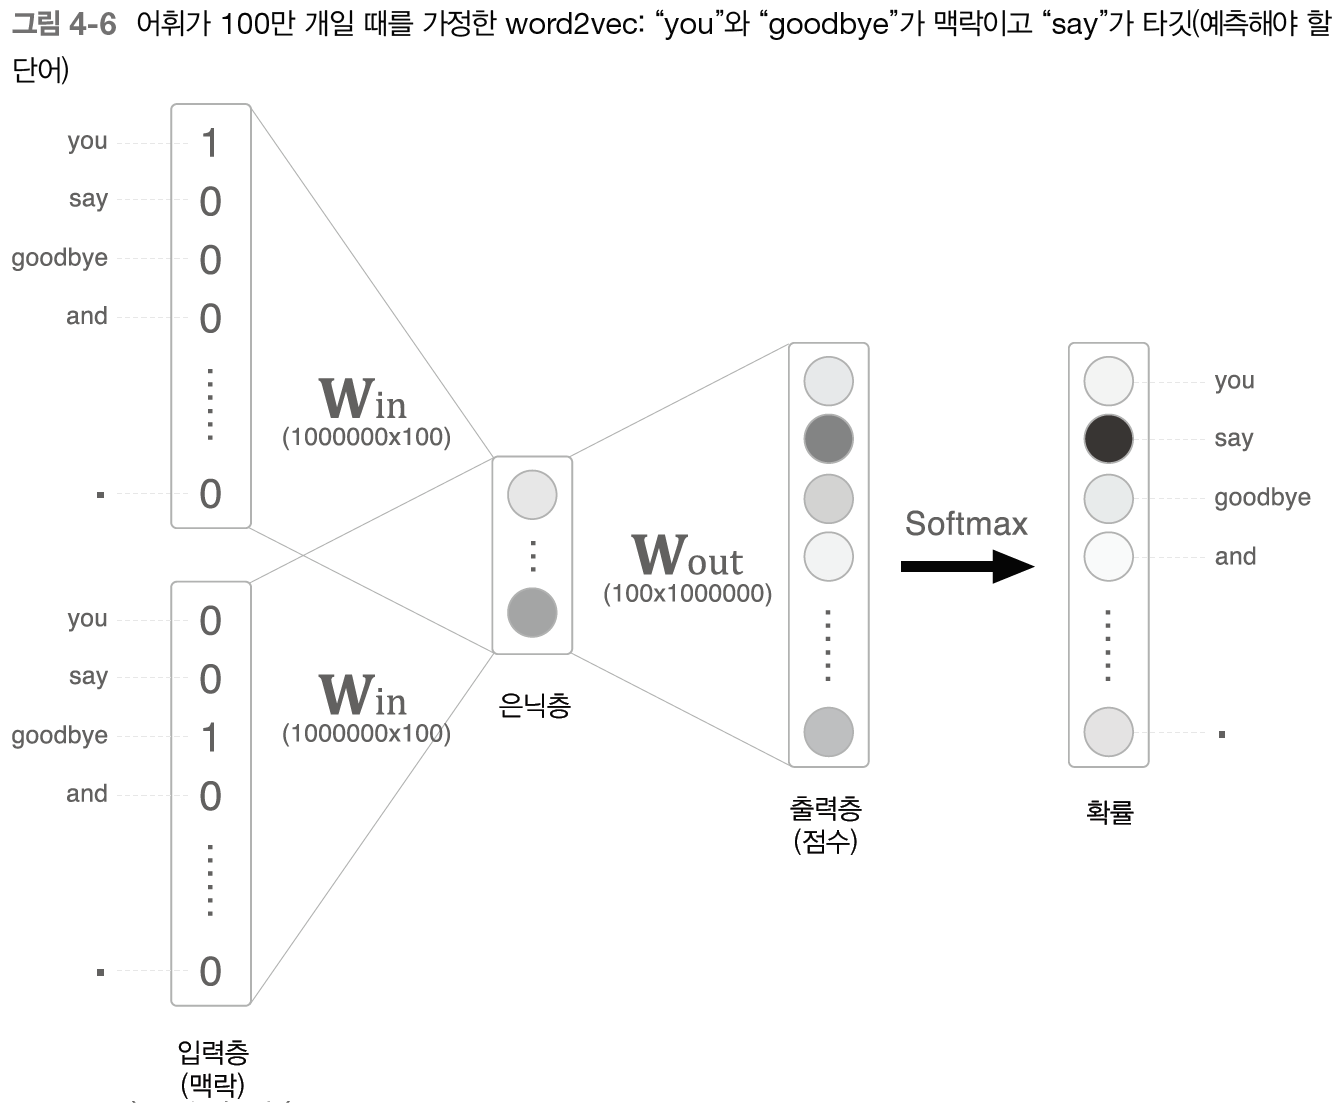

In [10]:
Image.open(os.path.join(img_path, 'fig 4-6.png'))

은닉층 이후 계산이 오래 걸리는 곳은 다음의 두 분이다.

- 은닉층의 뉴런과 가중치 행렬($\mathbf{W}_{\text{out}}$)의 곱
- Softmax 계층의 계산

첫 번째 문제의 경우 은닉층의 벡터 크기가 100, 가중치 행렬의 크기가 100 $\times$ 100만 이므로 행렬 곱 계산에 많은 시간 및 메모리가 소요된다.

또한 역전파 때도 같은 계산을 수행하므로 이 행렬 곱을 '가볍게' 만들어야 한다.

두 번째 문제는 Softmax에서도 같은 문제가 발생한다는 것이다.

\begin{equation*}
    y_k = \cfrac{\exp (s_k)}{\displaystyle\sum_{i=1}^{1,000,000} \exp (s_i)}
    \tag{4.1}
\end{equation*}

이 식을 보면 어휘 수가 100만 개인 경우에 분모의 계산을 하려면 `exp` 계산을 100만 번 수행해야 한다.

이 계산도 어휘 수에 비례해서 증가하므로 Softmax 대신에 더 '가벼운' 계산이 필요함을 알 수 있다.

### 4.2.2 다중 분류에서 이진 분류로

네거티브 샘플링 기법의 핵심 아이디어는 이진 분류(binary classification)에 있다.

더 정확히는 '다중 분류(multi-class classification)'를 '이진 분류'로 근사하는 것이 네거티브 샘플링을 이해하는 포인트이다.

지금까지는 맥락이 주어졌을 때 정답이 되는 단어를 높은 확률로 추측하도록 만드는 일을 했다. (여러 개의 단어가 주어졌을 때 모든 가능한 단어중 옳은 단어 선택하기)

이제부터 우리가 생각해야 할 것은 '다중 분류' 문제를 '이진 분류'방식으로 해결하는 것이다.

그러기 위해서는 "Yes/No" 로 답할 수 있는 질문을 생각해내야 한다.

예컨대 "맥락이 'you'와 'goodbye'일 때, 타깃 단어는 'say'입니까?" 라는 질문에 답하는 신경망을 생각해내야 한다.

이렇게 하면 출력층에는 뉴런을 하나만 준비하면 된다. 출력층의 이 뉴런이 'say'의 점수를 출력하는 것이다.

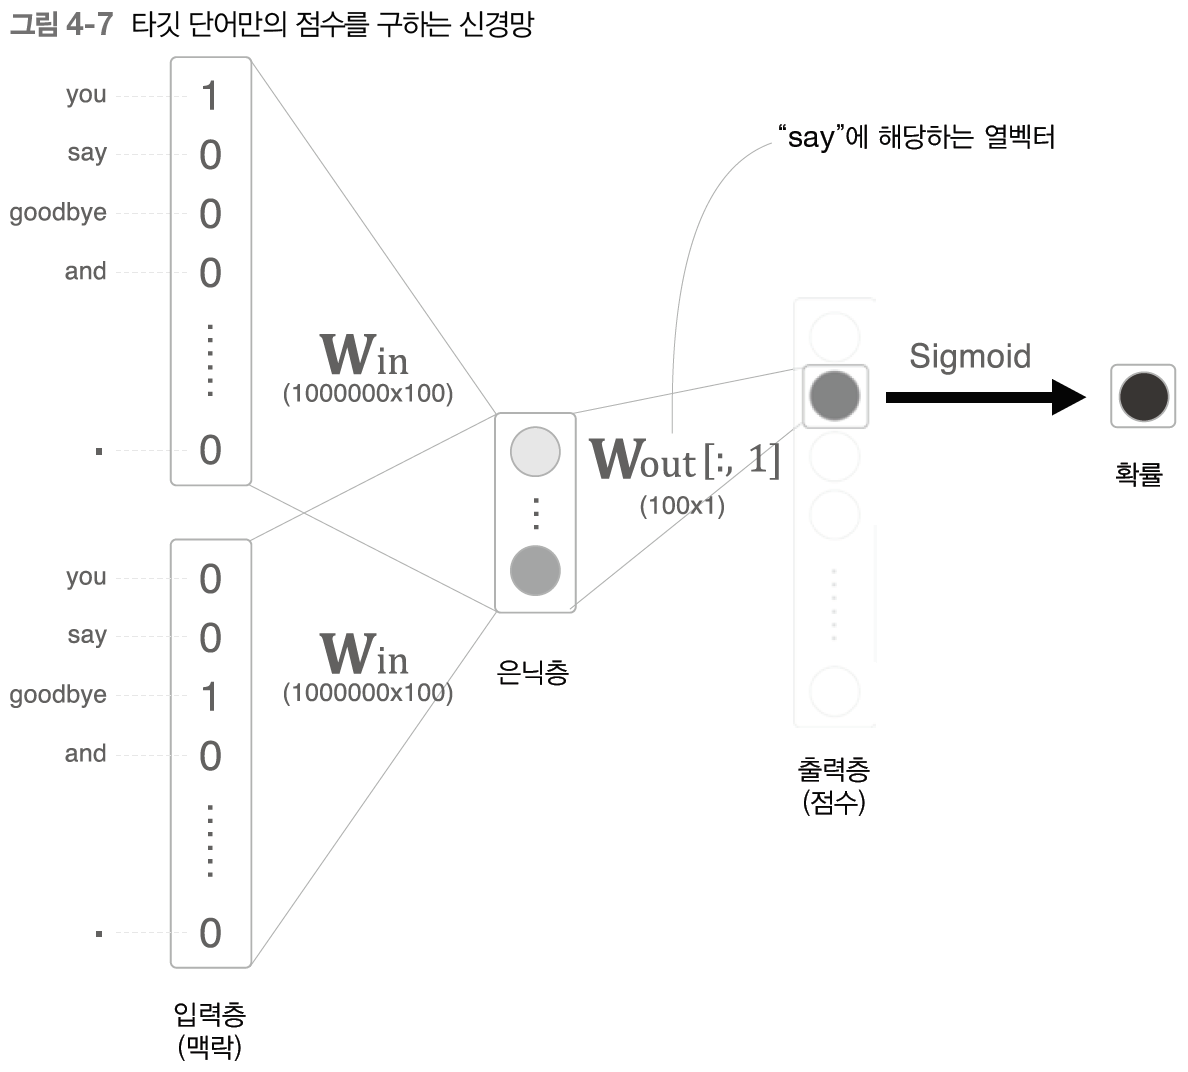

In [12]:
Image.open(os.path.join(img_path, 'fig 4-7.png'))

그림에서 보듯 출력층의 뉴런은 하나뿐이다.

따라서 은닉층과 출력 측의 가중치 행렬의 내적은 'say'에 해당하는 열(단어 벡터)만을 추출하고, 그 추출된 벡터와 은닉층 뉴런과의 내적을 계산하면 끝이다.

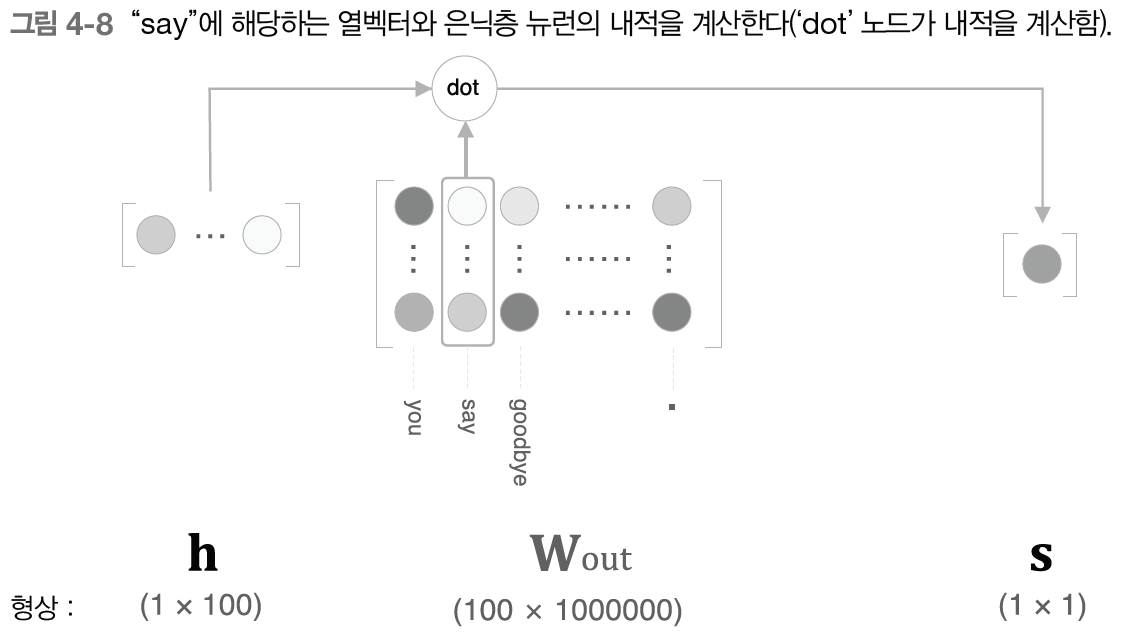

In [13]:
Image.open(os.path.join(img_path, 'fig 4-8.png'))

그림처럼 출력 측의 가중치 $\mathbf{W}_{\text{out}}$ 에서는 각 단어 ID의 단어 벡터가 각각의 열로 저장되어 있다.

이 예에서는 'say'에 해당하는 단어 벡터를 추출한다. 그리고 그 벡터와 은닉층 뉴런($\mathbf{h}$)과의 내적을 구한다.

이렇게 구한 값이 최종 점수 $\mathbf{s}$ 가 되는 것이다.

### 4.2.3 시그모이드 함수와 교차 엔트로피 오차

이진 분류 문제를 신경망으로 풀려면 점수에 시그모이드 함수를 적용해서 확률로 변환하고, 손실을 구할 때는 손실 함수로 '교차 엔트로피 오차'를 사용한다.

\begin{equation*}
    y = \cfrac{1}{1 + \exp (-x)} \quad (\text{시그모이드 함수})
    \tag{4.2}
\end{equation*}

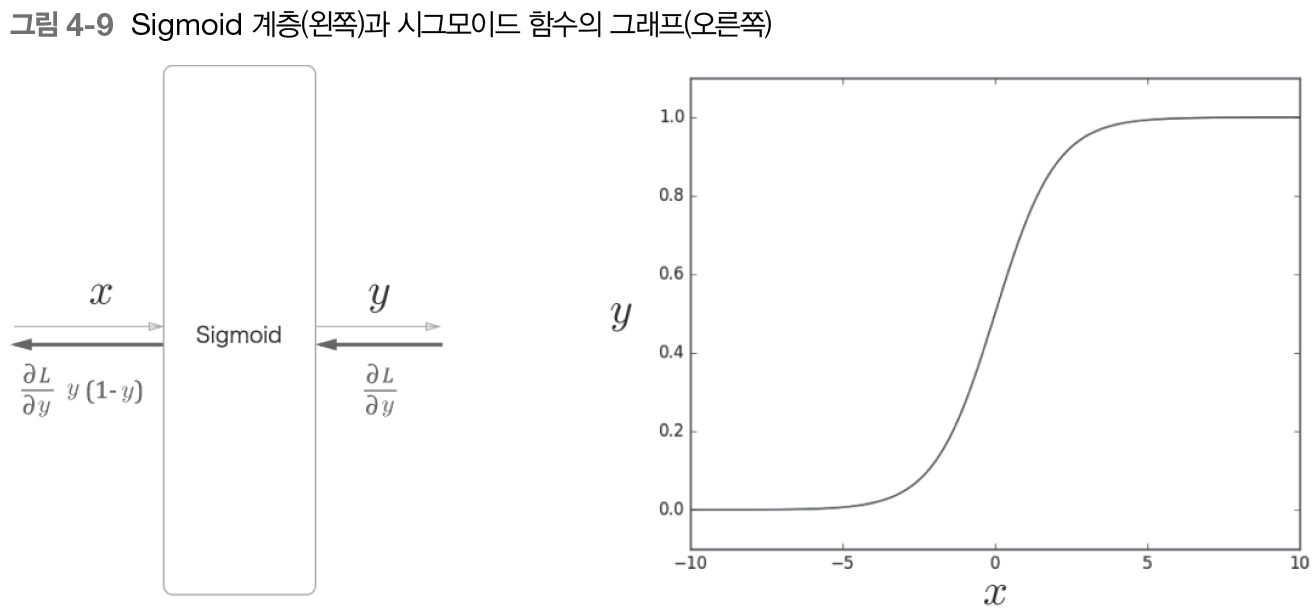

In [14]:
Image.open(os.path.join(img_path, 'fig 4-9.png'))

시그모이드 함수를 적용해서 확률 $y$ 를 얻으면, 이 확률 $y$ 로부터 손실을 구한다.

시그모이드 함수에 사용되는 손실 함수는 '교차 엔트로피 오차'로 다음과 같이 쓸 수 있다.

\begin{equation*}
    L = -\left( t\log y + (1-t) \log (1-y) \right)
    \tag{4.3}
\end{equation*}

이때 $y$ 는 시그모이드 함수의 출력, $t$ 는 정답 레이블으로, 0(No)아니면 1(Yes)이다.

Sigmoid 계층과 Cross Entropy Error 계층의 계산 그래프는 다음과 같다.

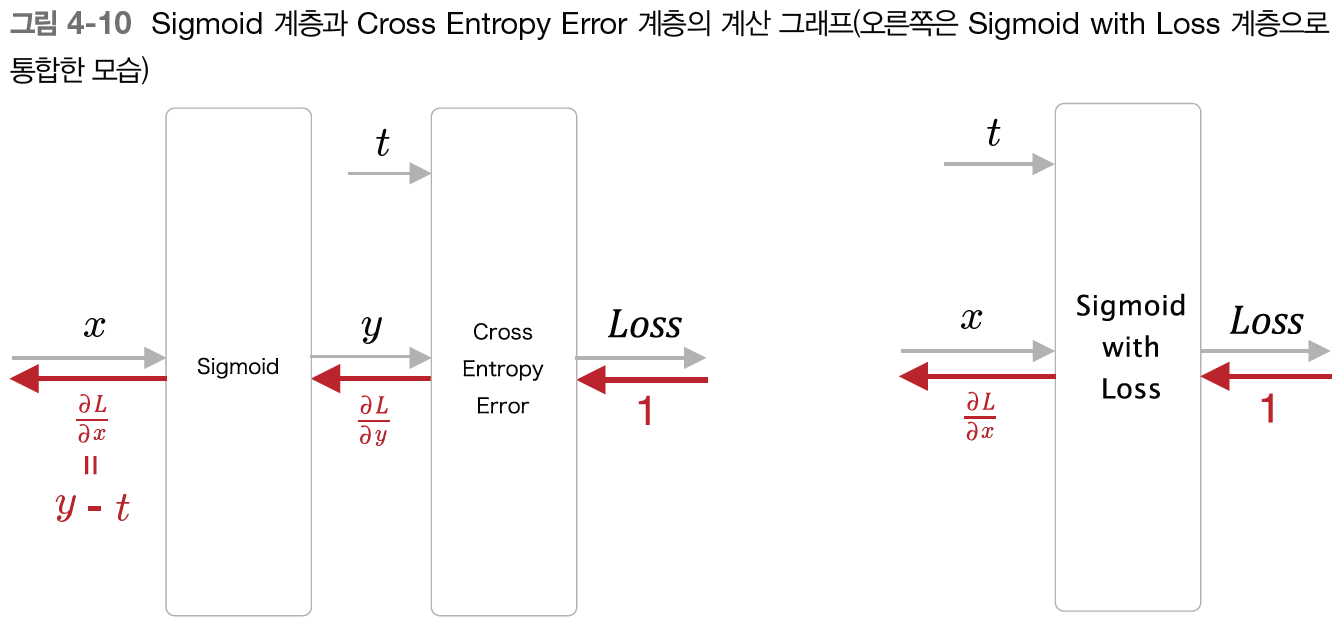

In [15]:
Image.open(os.path.join(img_path, 'fig 4-10.png'))

여기서 주목할 점은 역전파의 $y-t$ 값이다. 신경망이 출력한 확률과 정답 레이블의 차이가 가까워질수록 오차가 줄어든다는 것이다.

이러한 오차가 앞 계층으로 흘러가므로, 오차가 크면 '크게' 학습하고, 오차가 작으면 '작게' 학습하게 된다.

### 4.2.4 다중 분류에서 이진 분류로 (구현)

지금까지 다중 분류 문제를 다뤘다.

다중 분류에서는 출력층에 어휘 수만큼의 뉴런을 준비하고 이 뉴런들이 출력한 값을 Softmax에 통과시켰다.

이러한 신경망의 '계층'과 '연산'중심으로 그리면 다음과 같다.

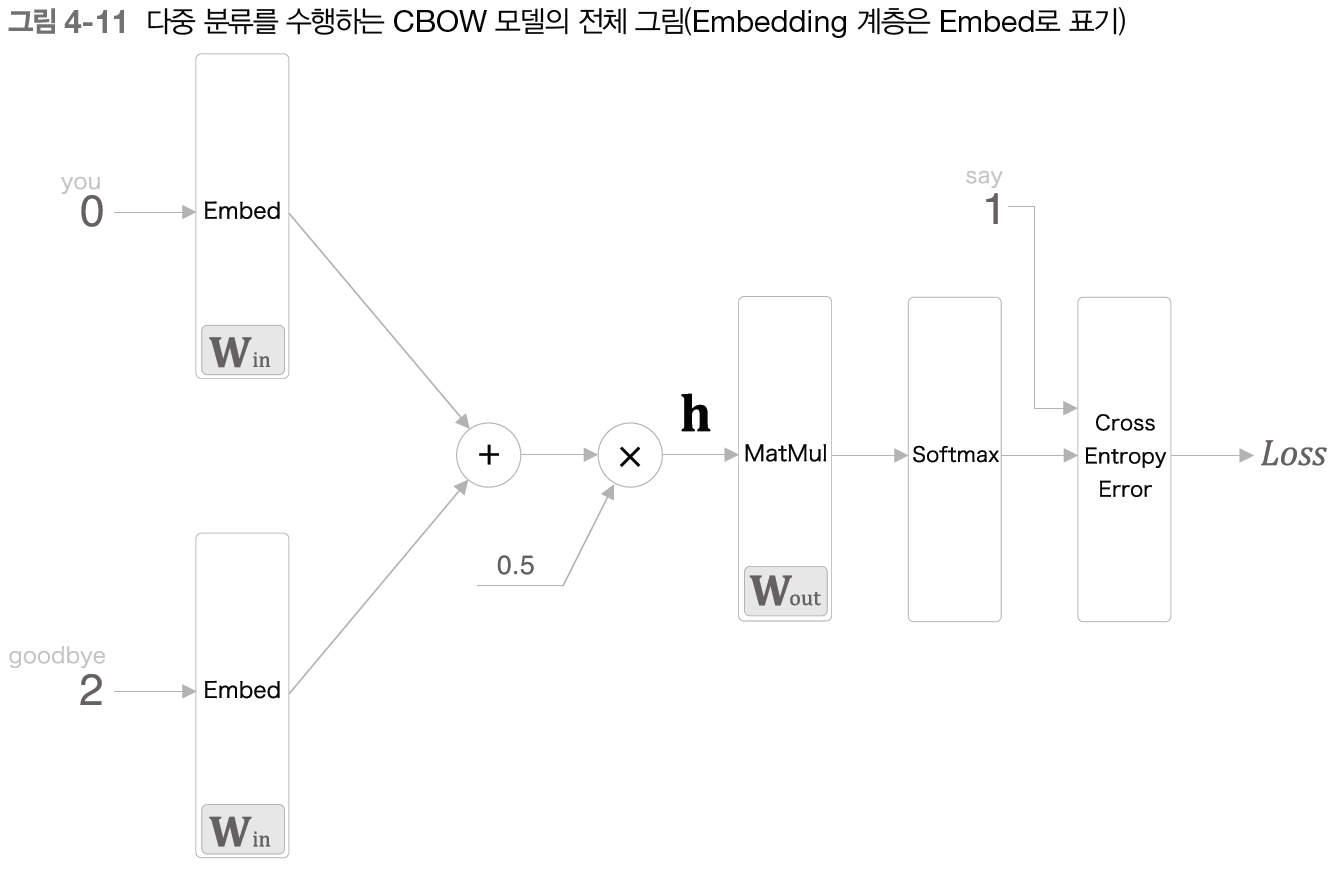

In [16]:
Image.open(os.path.join(img_path, 'fig 4-11.png'))

이제 이 신경망을 이진 분류 신경망으로 변환해보면 다음과 같이 그릴 수 있다.

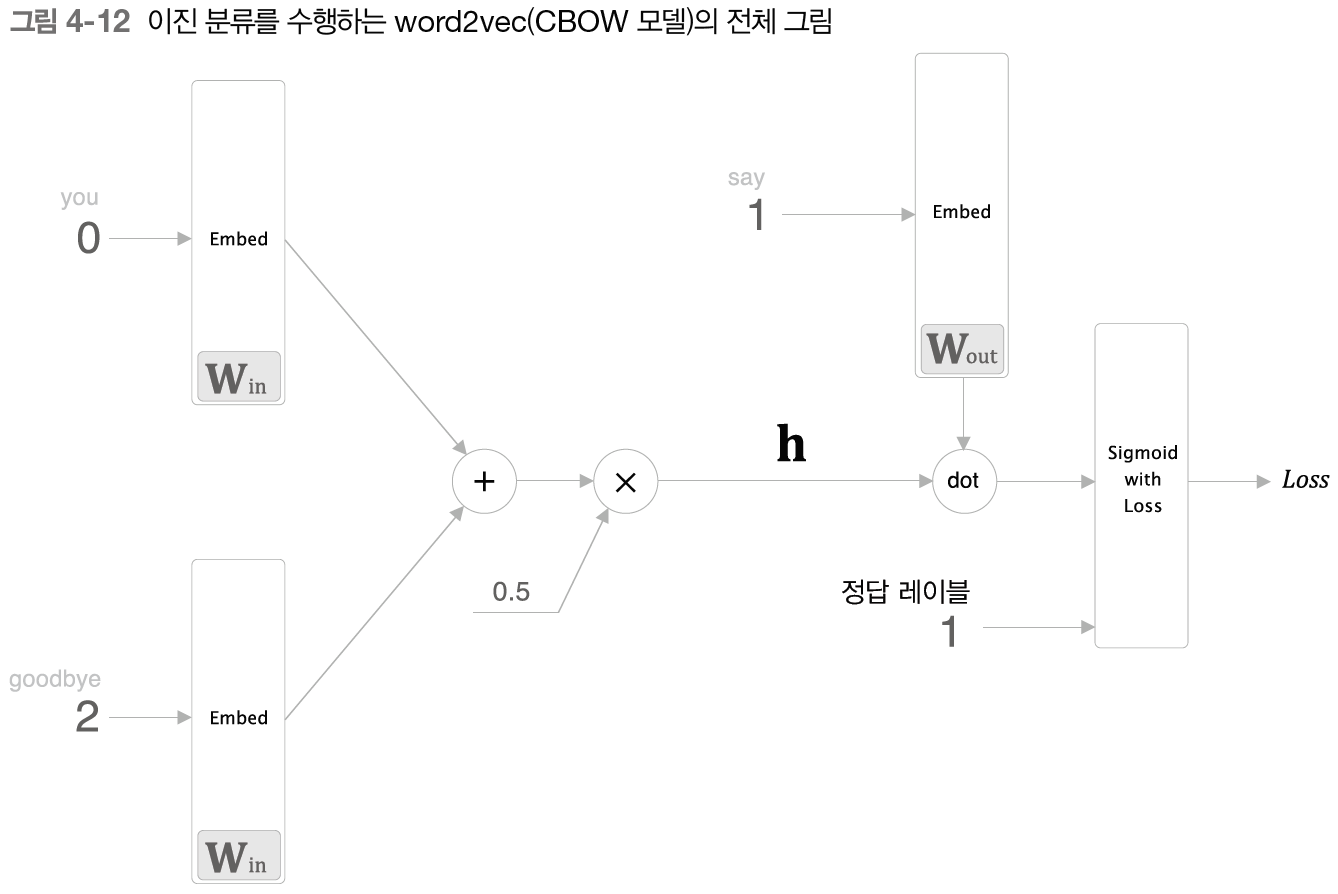

In [17]:
Image.open(os.path.join(img_path, 'fig 4-12.png'))

이때 은닉층 뉴런 $\mathbf{h}$ 와 출력 측의 가중치 $\mathbf{W}_{\text{out}}$ 에서 단어 'say'에 해당하는 단어 벡터와 내적을 계산한다.

그리고 그 출력을 Sigmoid with Loss 계층에 입력해서 최종 손실을 얻는다.

이 과정을 더 단순하게 만들어보고자 한다. 이를 위해 Embedding Dot 계층을 도입한다.

이 계층은 Embedding 계층과 'dot 연산(내적)'의 처리를 합친 계층이다.

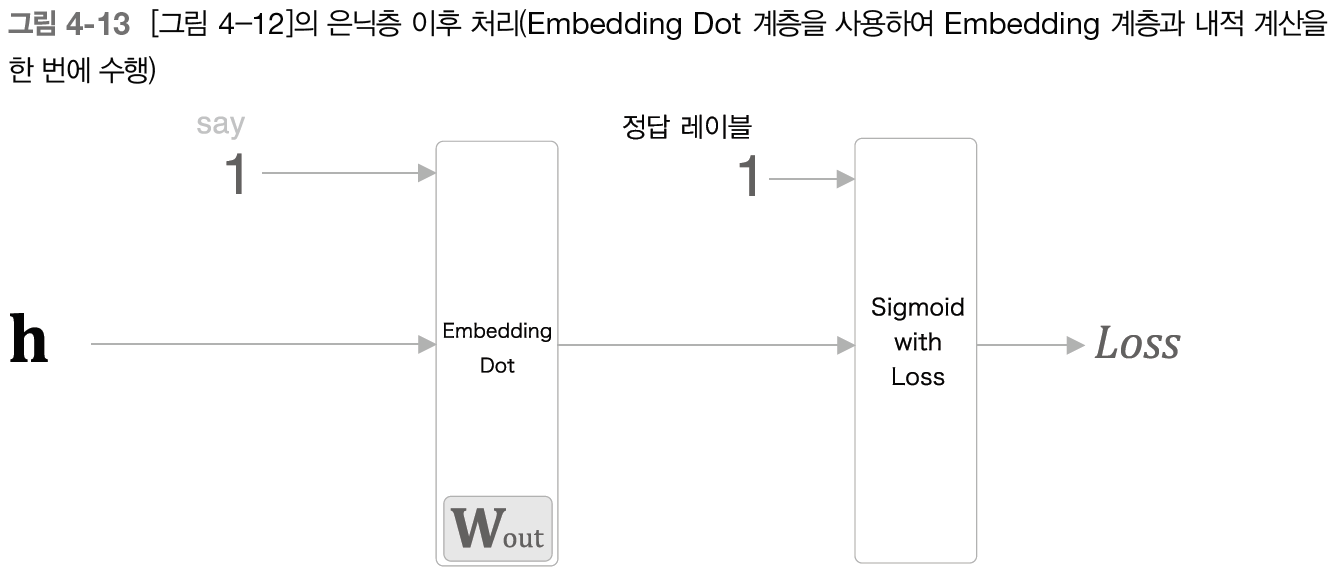

In [18]:
Image.open(os.path.join(img_path, 'fig 4-13.png'))

은닉층 뉴런 $\mathbf{h}$ 는 Embedding Dot 계층을 거쳐 Sigmoid with Loss 계층을 통과한다.

Embedding Dot 계층의 구현은 chapter04/negative_sampling_layer.py 를 참조한다.

`EmbeddingDot` 클래스에는 총 4개의 인스턴스 변수(`embed`, `params`, `grads`, `cache`)가 있다.

이 책의 구현 규칙대로 `params`에는 매개변수를 저장하고, `grads`에는 기울기를 저장한다.

또한 `embed`에는 `Embedding` 계층을, `cache`는 순전파 시의 계산 결과를 잠시 유지하기 위한 변수로 사용한다.

순전파를 담당하는 `forward(h, idx)` 메서드는 인수로 은닉층 뉴런`h` 과 단어 ID의 넘파이 배열 `idx`를 받는다.

여기서 `idx`는 단어 ID의 '배열'인데, 배열로 받는 이유는 데이터를 한꺼번에 처리하는 '미니배치 처리'를 가정했기 때문이다.

이 코드의 `forward()` 메서드에서는 우선 `Embedding` 계층의 `forward(idx)`를 호출한 다음 내적을 계산한다.

내적 계산은 `np.sum(self.target_W * h, axis = 1)` 이라는 한 줄의 코드로 이뤄진다.

In [21]:
import sys
sys.path.append('..')
from common.layers import Embedding

W, idx = np.arange(21).reshape(7, 3), [0, 3, 1]
h = W[0:3]
print(f'h : {h}')

embed = Embedding(W)

target_W = embed.forward(idx)

print(f'target_W : {target_W}')
out = np.sum(target_W * h, axis=1)
print(f'target_W * h : {target_W * h}')
print(f'out : {out}')

h : [[0 1 2]
 [3 4 5]
 [6 7 8]]
target_W : [[ 0  1  2]
 [ 9 10 11]
 [ 3  4  5]]
target_W * h : [[ 0  1  4]
 [27 40 55]
 [18 28 40]]
out : [  5 122  86]


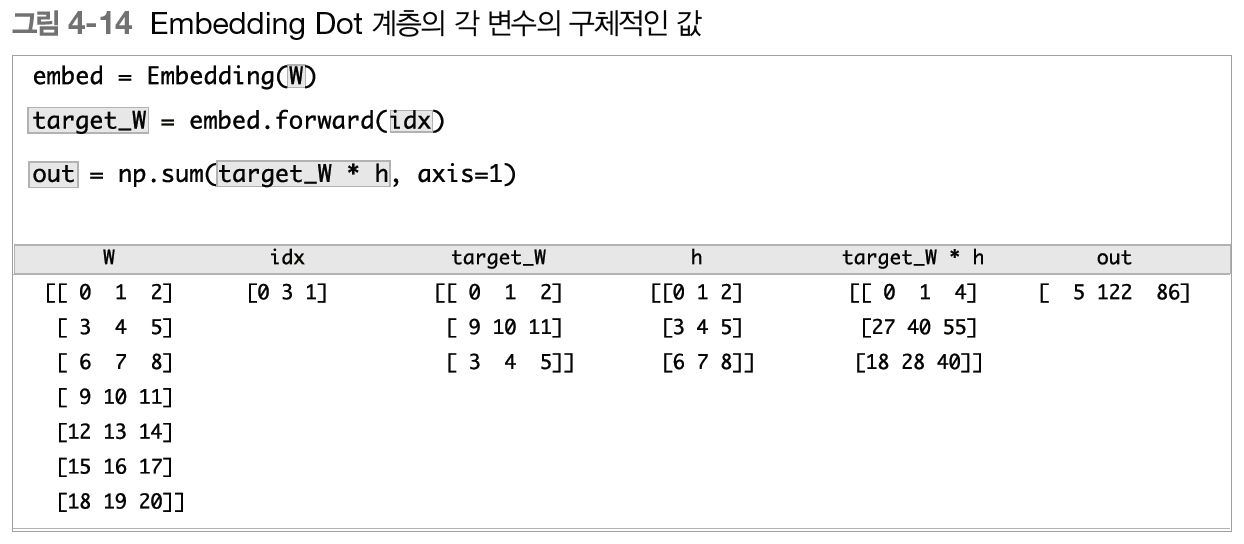

In [22]:
Image.open(os.path.join(img_path, 'fig 4-14.png'))

여기서 `target_W * h`는 각 원소의 곱을 계산한다(넘파이 배열의 * 연산은 원소별 곱을 수행).

그리고 이 결과를 행마다 (`axis = 1`) 전부 더해서 최종 결과 `out`을 얻는다.

이상이 `EmbeddingDot` 계층의 순전파이다. 역전파는 순전파의 반대 순서로 기울기를 전달해서 구현한다.

### 4.2.5 네거티브 샘플링

지금까지 배운 것으로 주어진 문제를 '다중 분류'에서 '이진 분류'로 변환할 수 있었다.

하지만 이것만으로는 문제가 해결되지 않는다. 긍정적인 예(정답)에 대해서만 학습했기 때문에,

부정적인 예(오답)를 입력하면 어떤 결과가 나올지 알 수 없다.

앞선 예에서 맥락은 'you', 'goodbye' 였고 정답 타깃은 'say'였다.

우리는 지금까지 긍정적 예인 'say'만을 대상으로 이진 분류를 해왔다.

만약 여기서 '좋은 가중치'가 준비되어 있다면 Sigmoid 계층의 출력은 1에 가까워질 것이다(확률).

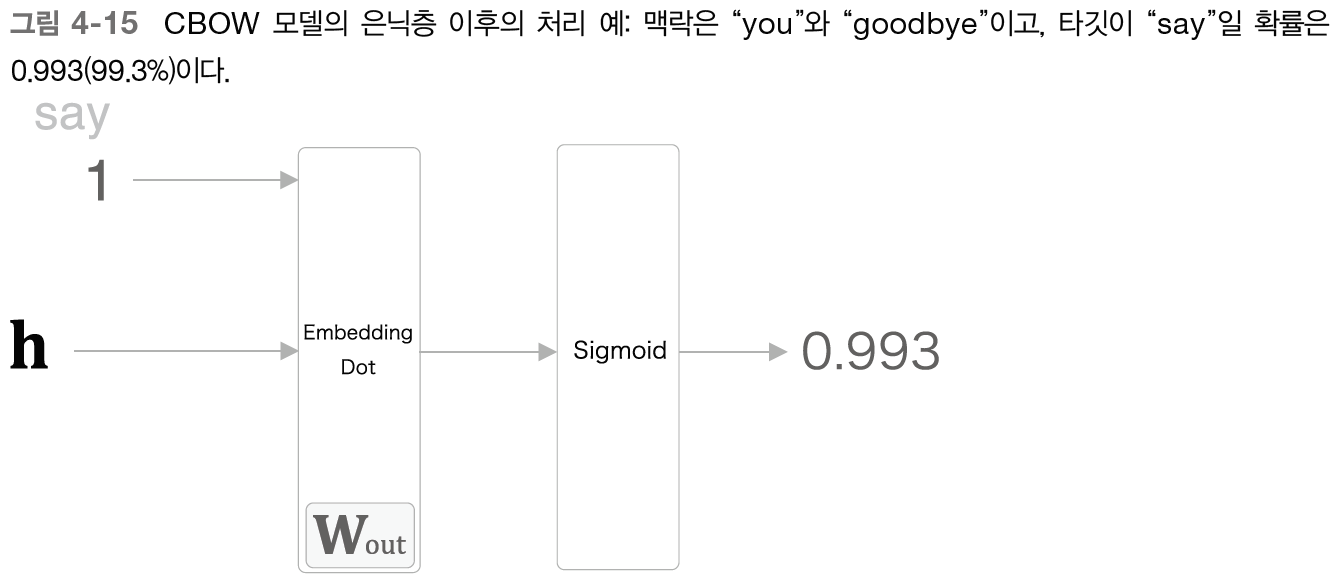

In [23]:
Image.open(os.path.join(img_path, 'fig 4-15.png'))

현재의 신경망에서는 긍정적 예인 'say'에 대해서만 학습하게 된다.

그러나 부정적 예('say'이외의 단어)에 대해서는 어떠한 지식도 획득 못했다.

여기서 우리가 하고싶은건 긍정적 예('say')에 대해서는 Sigmoid 계층의 출력을 1에 가깝게 만들고, 부정적 예('say'이외의 단어)에 대해서는 Sigmoid 계층의 출력을 0에 가깝게 만드는 것이다.


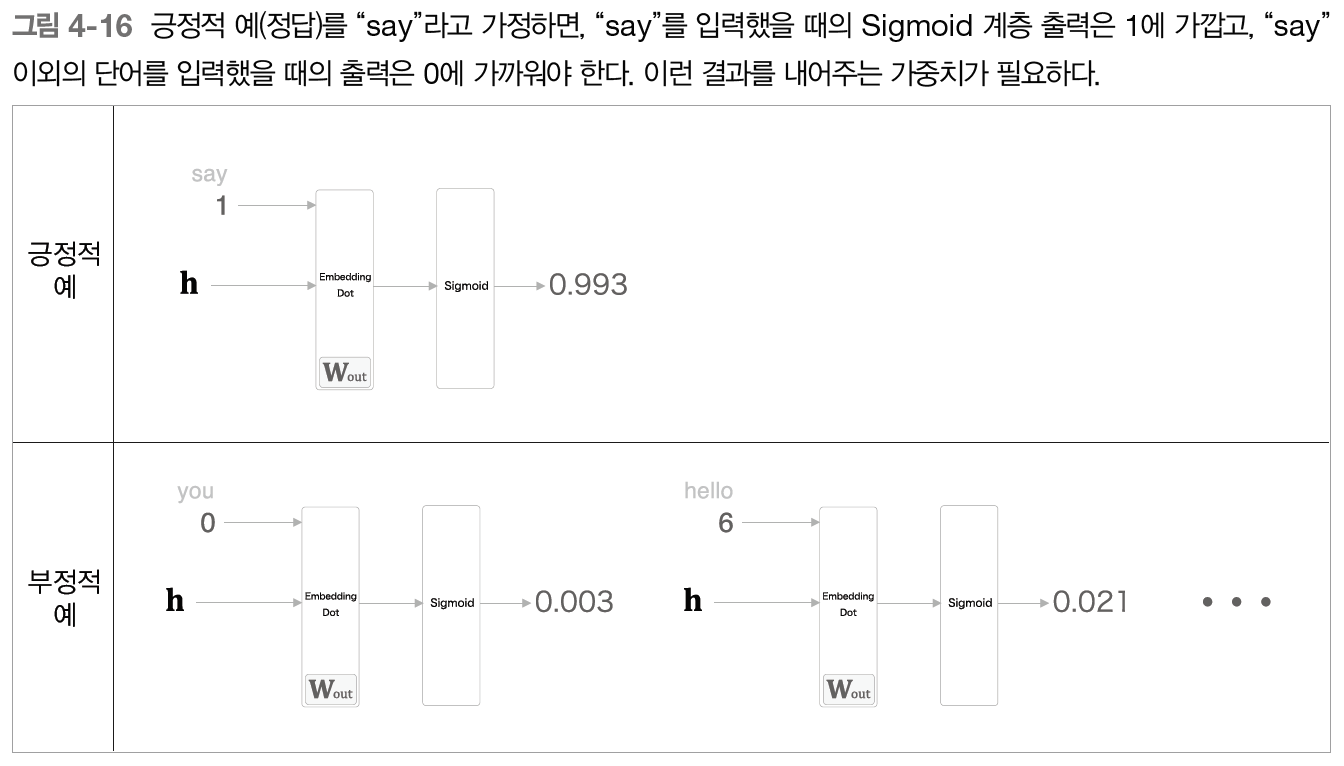

In [24]:
Image.open(os.path.join(img_path, 'fig 4-16.png'))

예를 들어 맥락이 'you', 'goodbye'일 때, 타깃이 'hello'일 확률(틀린 단어일 경우의 확률)은 낮은 값이어야 바람직하다.

그래서 이러한 부정적 예도 다룰 수 있게끔 하는 가중치가 필요하다.

$\textbf{NOTE}$

다중 분류 문제를 이진 분류로 다루려면 '정답(긍정적 예)'과 '오답(부정적 예)' 각각에 대해 바르게 (이진) 분류할 수 있어야 한다. 따라서 긍정적 예와 부정적 예 모두를 대상으로 문제를 생각해야 한다.

그렇다고 해서 모든 부정적 예를 대상으로 이진 분류를 학습시킬 순 없다.

모든 부정적 예를 대상으로 하게 되면 어휘 수가 늘어날 경우 감당불가능이다.

그래서 근사적인 해법으로, 부정적 예를 몇 개(5개, 10개 등) 선택한다.

즉, 적은 수의 부정적 예를 샘플링해서 사용한다.

이것이 바로 '네거티브 샘플링'기법이 의미하는 바이다.

정리하면, 네거티브 샘플링 기법은 긍정적 예를 타깃으로 한 경우의 손실을 구하면서 부정적 예를 몇 개 샘플링하여, 그 부정적 예에 대해서도 마찬가지로 손실을 구한다.

그리고 각각의 데이터(긍정적 예와 샘플링된 부정적 예)의 손실을 더한 값을 최종 손실로 한다.

다음 그림은 부정적 예의 타깃을 2개('hello', 'I')샘플링했다고 가정했을 때의 네거티브 샘플링 계산 그래프이다.

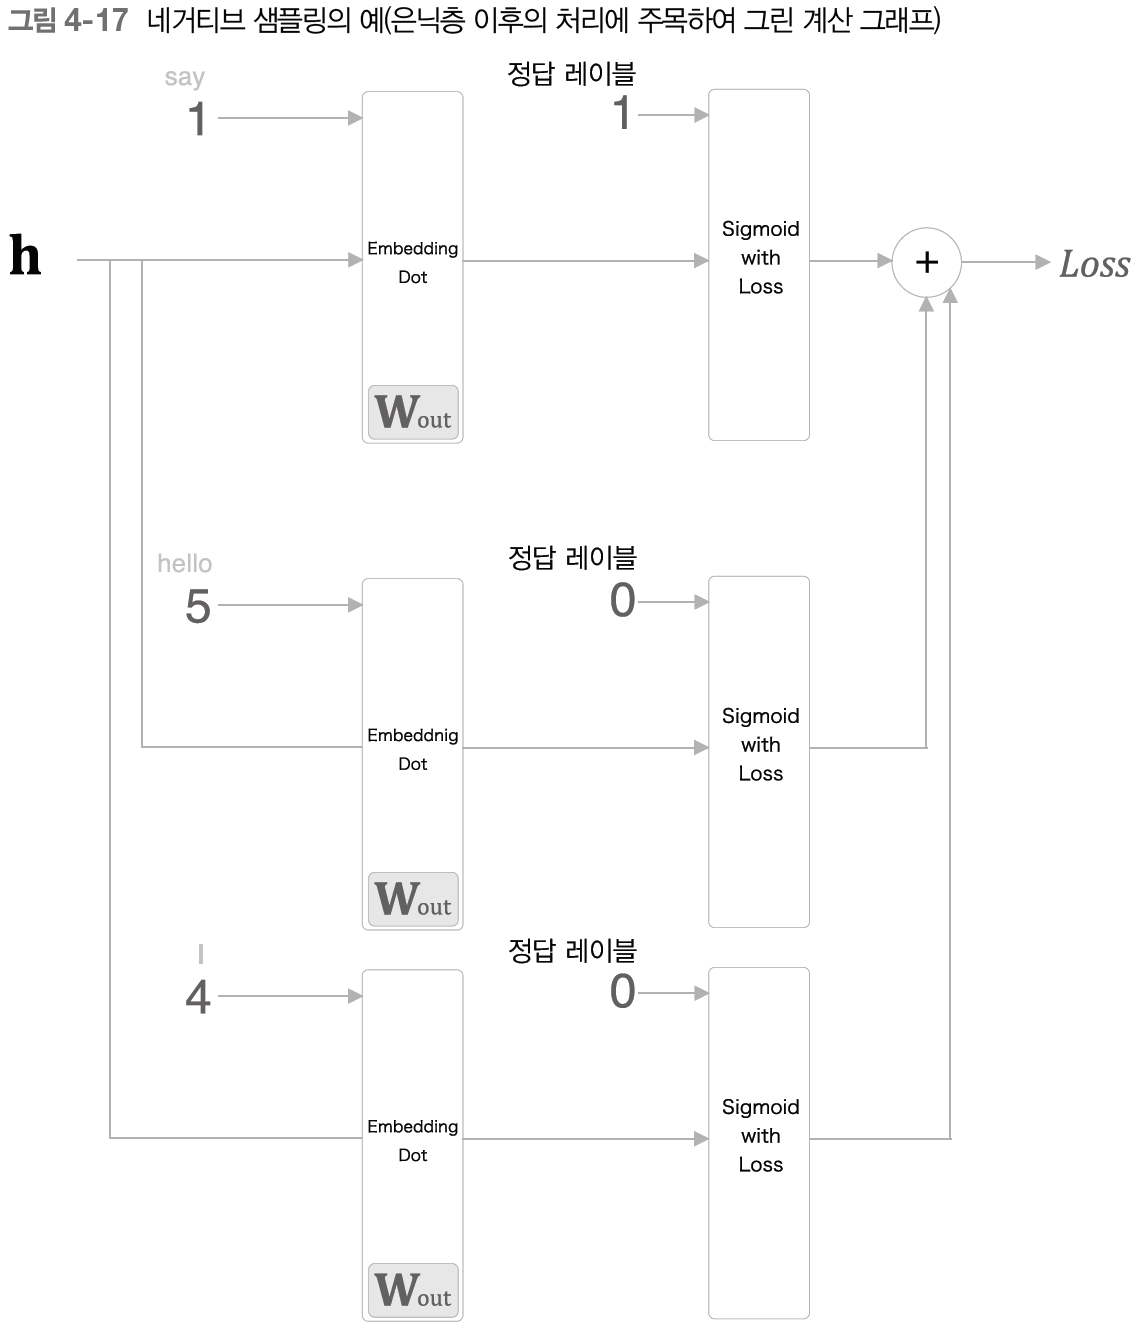

In [25]:
Image.open(os.path.join(img_path, 'fig 4-17.png'))

여기서 주의할 부분은 긍정적 예와 부정적 예를 다루는 방식이다.

긍정적 예에 대해서는 Sigmoid with Loss 계층에 정답 레이블로 '1'을 입력하지만,

부정적 예에 대해서는 Sigmoid with Loss 계층에 정답 레이블로 '0'을 입력한다.

그런 다음 각 데이터의 손실을 모두 더해서 최종 손실을 출력한다.

### 4.2.6 네거티브 샘플링의 샘플링 기법

네거티브 샘플링에서 중요한 포인트가 하나 있다.

부정적 예를 어떻게 샘플링하느냐 인데, 단순히 무작위로 샘플링하는 것보다 더 좋은 방법이 존재한다.

바로 말뭉치의 통계 데이터를 기초로 샘플링하는 방법이다.

구체적으로는 말뭉치에서 자주 등장하는 단어를 많이 추출하고, 드물게 등장하는 단어를 적게 추출하는 방식이다.

말뭉치에서의 단어 빈도를 기준으로 샘플링하려면, 먼저 말뭉치에서 각 단어의 출현 횟수를 구해서 '확률 분포'로 나타낸다.

그 다음 그 확률분포대로 단어를 샘플링하는 것이다.

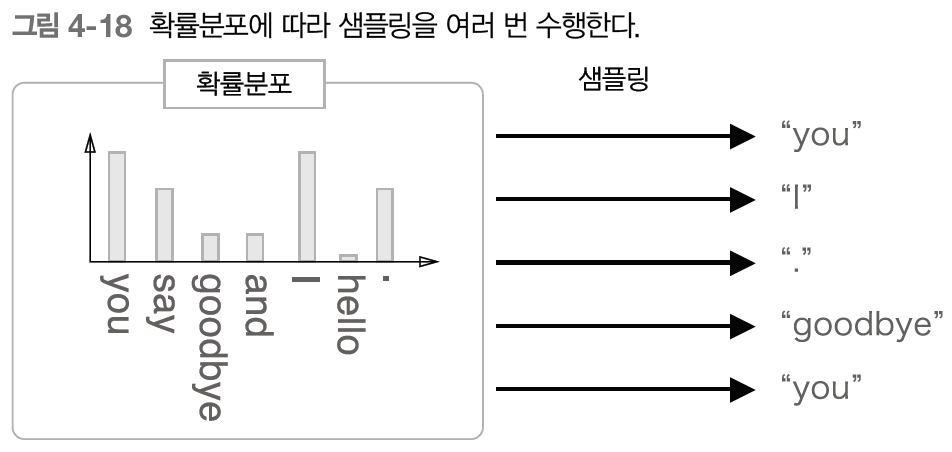

In [27]:
Image.open(os.path.join(img_path, 'fig 4-18.png'))

확률분포대로 샘플링하므로 말뭉치에서 자주 등장하는 단어는 선택될 가능성이 높다.

같은 이유로, '희소한 단어'는 선택되기 어렵다.

$\textbf{NOTE}$

네거티브 샘플링에서는 부정적 예를 가능한 한 많이 다루는 것이 좋다. 그러나 계산량 문제때문에 적은 수(5개나 10개)로 한정해야 한다. 만약 우연히 '희소한 단어'만 선택된 경우, 당연히 결과도 나빠진다. 왜냐하면 실전 문제에서도 희소한 단어는 거의 출현하지 않기 때문이다. 즉, 드문 단어를 잘 처리하는 일은 중요도가 낮다. 그보다는 흔한 단어를 처리하는 편이 좋은 결과로 이어지게 된다.

다음은 확률분포에 따라 샘플링하는 예이다. 이 예에서는 넘파이의 `np.random.choice()`를 사용한다.

In [28]:
import numpy as np

# 0에서 9까지의 숫자 중 하나를 무작위로 샘플링
print(np.random.choice(10))
print(np.random.choice(10))

# words에서 하나만 무작위로 샘플링
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
print(np.random.choice(words))

# 5개만 무작위로 샘플링(중복 있음)
print(np.random.choice(words, size=5))  

# 5개만 무작위로 샘플링(중복 없음)
print(np.random.choice(words, size=5, replace=False))

# 확률분포에 따라 샘플링
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
print(np.random.choice(words, p=p))

8
0
I
['.' '.' '.' 'say' 'I']
['.' 'say' 'goodbye' 'hello' 'I']
you


`np.random.choice()` 함수 인수 설명

- `size` : 샘플링을 `size` 만큼 수행
- `replace` : `replace = False` 지정시에 비복원추출 시행 (`True` 면 복원추출)
- `p` : `p`에 확률분포를 담은 리스트를 지정시 그 확률분포대로 샘플링 수행

마지막으로 word2vec의 네거티브 샘플링에서는 앞의 확률분포에서 한 가지를 수정하라고 권고한다.

다음 식과 같이 기본 확률분포에 0.75를 제곱하는 것이다.

\begin{equation*}
    P'(w_i) = \cfrac{P(w_i)^{0.75}}{\displaystyle\sum_{j=1}^{n}P(w_j)^{0.75}}
    \tag{4.4}
\end{equation*}

여기서 $P(w_i)$ 는 $i$ 번째 단어의 확률을 뜻한다.

즉 식 (4.4)는 기존의 어휘 확률분포에 0.75를 제곱해주고, 여기에 normalizing constant를 곱해준 것 뿐이다.

위와 같은 변형을 준 이유는 출현 확률이 낮은 단어를 '버리지' 않기 위해서이다.

이를 통해 원래 확률이 낮은 단어의 확률을 살짝 높일 수 있다. (참고로 0.75수치에는 이론적인 의미는 없으니 다른 값으로 설정해도 된다)

In [29]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


이렇듯 네거티브 샘플링은 말뭉치에서 단어의 확률분포를 만들고, 다시 0.75를 제곱한 다음 정규화를 수행한다. 마지막으로 `np.random.choice()` 를 통해 부정적 예를 샘플링한다.

이 처리를 담당하는 클래스를 `UnigramSampler`로 구현한다. (chapter04/negative_sampling_layer.py 참조)

$\textbf{NOTE}$

$\text{유니그램}^{\text{Unigram}}$ 이란 '하나의 (연속된) 단어'를 뜻한다. 같은 요령으로 $\text{바이그램}^{\text{Bigram}}$ 은 '2개의 연속된 단어'를, $\text{트라이그램}^{\text{Trigram}}$ 은 '3개의 연속된 단어'를 뜻한다. 즉 `UnigramSampler` 클래스의 이름에는 한 단어를 대상으로 확률분포를 만든다는 의미가 녹아있다. 만약 이를 '바이그램'버전으로 만든다면 ('you', 'say'), ('you', 'goodbye')와 같이 두 단어로 구성된 대상에 대한 확률분포를 만들게 된다.

`UnigramSampler` 클래스는 초기화 시 3개의 인수를 받는다. 단어 ID 목록인 `corpus`, 확률분포에 '제곱'하는 값 `power`, '부정적 예 샘플링'을 수행하는 횟수인 `sample_size`이다.

또한 `UnigramSampler` 클래스는 `get_negative_sample(target)` 메서드를 제공한다. 이 메서드는 `target` 인수로 지정된 단어를 긍정적 예로 보고, 그 외의 단어 ID를 샘플링한다.

In [30]:
from negative_sampling_layer import UnigramSampler

corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[3 2]
 [0 1]
 [4 3]]


위 예제에서는 긍정적 예로 [1, 3, 0]이라는 3개의 데이터를 미니배치로 다뤘다.

각각의 데이터에 대해서 부정적 예를 2개씩 샘플링한다. 여기서 첫 번째 데이터에 대한 부정적 예는 [3, 2],

두 번째 데이터에 대한 부정적 예는 [0, 1], 세 번째 데이터에 대한 부정적 예는 [4, 3]이 뽑혔음을 알 수 있다.

### 4.2.7 네거티브 샘플링 구현

네거티브 샘플링 구현 코드 참조 : `NegativeSamplingLoss` (chapter04/negative_sampling_layer.py)

초기화 메서드 인수

- `W` : 출력 측 가중치
- `corpus` : 말뭉치(단어 ID의 리스트)
- `power` : 확률분포에 제곱하는 값
- `sample_size` : 부정적 예의 샘플링 횟수

여기서 `UnigramSampler` 클래스를 생성하여 인스턴스 변수인 `sampler`로 저장한다. 샘플링 횟수는 `sample_size`에 저장한다.

- `loss_layers` : `SigmoidWithLoss` 계층을 부정적 예를 다루는 개수 `sample_size`만큼, 긍정적 예를 다루는 1개를 리스트로 보관한다.
- `embed_dot_layers` : `EmbeddingDot(W)` 계층을 부정적 예를 다루는 개수 `sample_size`만큼, 긍정적 예를 다루는 1개를 리스트로 보관한다.

그런 다음 이 계층에서 사용하는 매개변수와 기울기를 각각 배열로 저장한다.

`forward()` 메서드인수

- `h` : 은닉층 뉴런
- `target` : 긍정적 예의 타깃

이 메서드에서는 우선 `self.sampler`를 통해 부정적 예를 샘플링하여 `negative_sample`에 저장한다.

그런 다음 긍정적 예와 부정적 예 각각의 데이터에 대해서 순전파를 수행하여 그 손실들을 더한다.

구체적으로는 `EmbeddingDot`계층의 `forward` 점수를 구하고, 이어서 이 점수와 레이블을 `SigmoidwithLoss`계층으로 흘려 손실을 구한다.

`backward()` 메서드

역전파는 순전파 때의 역순으로 각 계층의 `backward()`를 호출하기만 하면 된다. 

은닉층의 뉴런은 순전파 시에 여러 개로 복사되었다. (Repeat 노드)

따라서 역전파 때는 여러 개의 기울기 값을 더해준다.

## 4.3 개선판 word2vec 학습

이제 완성된 Embedding 계층과 네거티브 샘플링 기법을 활용하고자 한다.

PTB 데이터셋을 사용하여 개선된 CBOW 모델을 학습하고 더 실용적인 단어의 분산 표현을 얻어보고자 한다.

### 4.3.1 CBOW 모델 구현

개선된 CBOW 클래스는 chapter04/cbow.py를 참조

`CBOW` 클래스 메서드

- `vocab_size` : 어휘 수
- `hidden_size` : 은닉층의 뉴런 수
- `corpus` : 단어 ID 목록
- `window_size` : 맥락의 크기

가중치 초기화가 끝나면 계층을 생성하는데, `Embedding`계층을 `2 * window_size`만큼 작성하여 인스턴스 변수 `in_layers`에 배열로 보관한다.

그런 다음 `NegativeSamplingLoss` 계층을 생성한다.

계층 생성이 끝난 뒤에는 이 신경망에서 쓰이는 모든 매개변수와 기울기를 `params`와 `grads`에 모은다.

마지막으로 단어의 분산 표현에 접근할 수 있게끔 인스턴스 변수 `word_vecs`에 가중치 `W_in`을 할당한다.

`forward()`와 `backward()` 메서드는 각 계층의 순전파(혹은 역전파)를 적절한 순서로 호출할 뿐이다.

단, `forward(contexts, target)`메서드가 인수로 받는 맥락과 타깃이 단어 ID라는 점이 다르다(앞선 `SimpleCBOW`에서는 단어 ID를 원핫 벡터로 변환해서 사용했다).

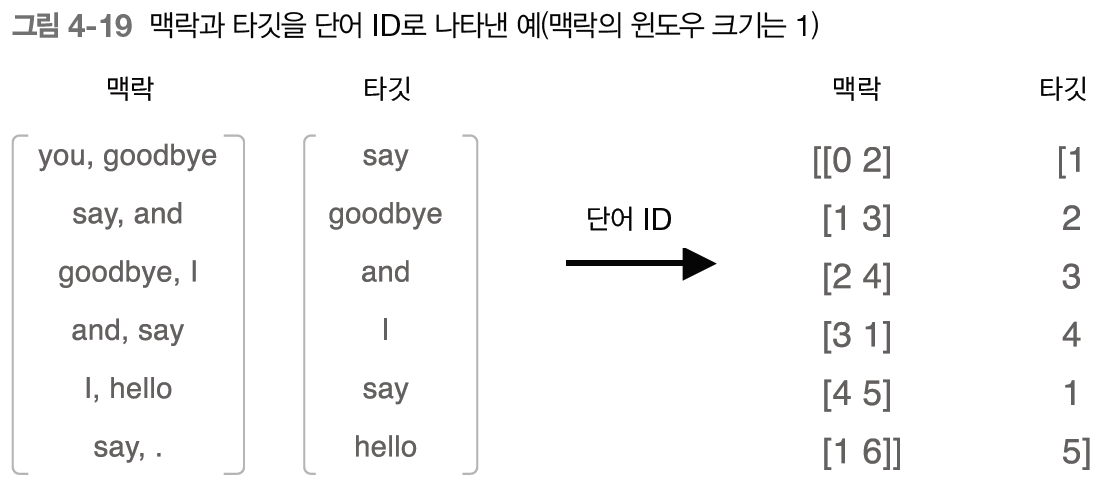

In [32]:
Image.open(os.path.join(img_path, 'fig 4-19.png'))

### 4.3.2 CBOW 모델 학습 코드

CBOW 모델 학습 코드는 chapter04/train.py 참조

### 4.3.3 CBOW 모델 평가

2장에서 구현한 `most_similar()`메서드를 이용하여, 단어 몇 개에 대해 거리가 가장 가까운 단어들을 뽑아본다 (chapter04/eval.py)

```
[query] you
 we: 0.75732421875
 i: 0.70849609375
 they: 0.62890625
 your: 0.61181640625
 someone: 0.58203125

[query] year
 month: 0.857421875
 week: 0.748046875
 summer: 0.74169921875
 spring: 0.7138671875
 decade: 0.69384765625

[query] car
 truck: 0.62060546875
 cars: 0.60888671875
 auto: 0.59814453125
 window: 0.59619140625
 luxury: 0.564453125

[query] toyota
 minicomputers: 0.63916015625
 engines: 0.63623046875
 honda: 0.6328125
 mazda: 0.623046875
 coated: 0.60595703125
```

결과를 보면, 'you' 에 대해서 비슷한 단어로 인칭대명사 'i'와 'we'등이 나왔다.

'year'에 대해서는 'month'와 'week'같은 성격의 단어들이 나왔다.

'toyota'에 대해서는 'honda', 'mazda' 같은 자동차 메이커가 나왔다.

이 정도 결과를 보면 CBOW 모델로 획득된 단어의 분산 표현은 제법 괜찮은 특성을 지닌다고 말할 수 있다.

word2vec으로 얻은 단어의 분산 표현은 비슷한 단어를 가까이 모을 뿐 아니라, 더 복잡한 패턴을 파악하는 것으로 알려져 있다.

대표적인 예가 "king - man + woman = queen"으로 유명한 유추 문제(비유 문제)이다.

더 정확하게 말하면, word2vec의 단어의 분산 표현을 사용하면 유추 문제를 덧셈과 뺄셈으로 풀 수 있다는 뜻이다.

실제로 유추 문제를 풀려면 다음 그림과 같이 단어 벡터 공간에서 "man $\rightarrow$ woman" 벡터와 "king $\rightarrow$ ?" 벡터가 가능한 한 가까워지는 단어를 찾는다. 

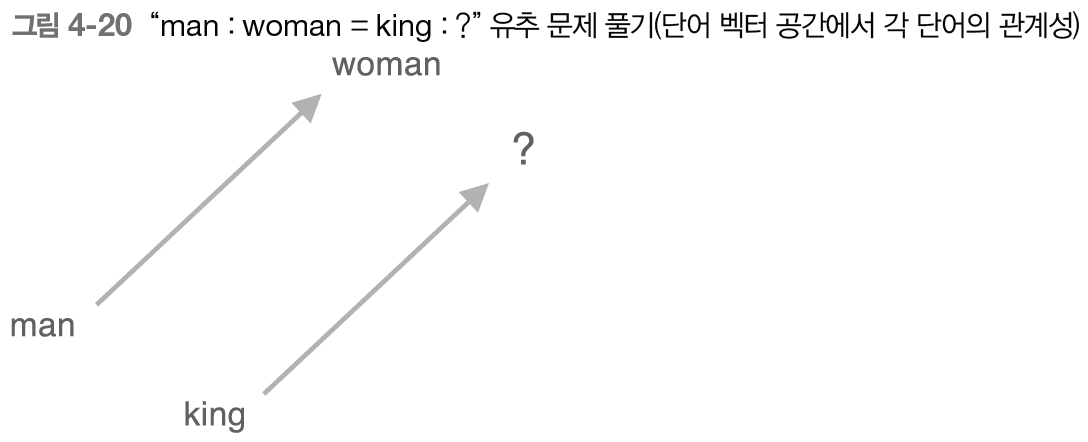

In [33]:
Image.open(os.path.join(img_path, 'fig 4-20.png'))

즉, 단어 'man'의 분산 표현(단어 벡터)을 "vec('man')"이라고 하면,

우리가 얻고 싶은 관계는 "vec('woman') - vec('man') = vec(?) - vec('king')"이 된다.

다시 말해 "vec('woman') + vec('king') - vec('man') = vec(?)" 와 가장 가까운 단어 벡터를 구하는 일이 된다.

이 로직을 구현한 함수는 common/util.py 의 `analogy()`이다.

이 함수의 실행 결과는 다음과 같다.

```
[analogy] king:man = queen:?
 woman: 5.16796875
 downside: 5.1171875
 toxin: 4.86328125
 carolinas: 4.796875
 wife: 4.71875

[analogy] take:took = go:?
 're: 4.59765625
 were: 4.578125
 went: 4.265625
 succeeds: 4.19921875
 came: 4.19140625

[analogy] car:cars = child:?
 a.m: 7.78515625
 rape: 5.99609375
 daffynition: 5.39453125
 children: 5.06640625
 adults: 4.8984375

[analogy] good:better = bad:?
 rather: 5.8828125
 more: 5.796875
 less: 5.3125
 greater: 4.109375
 worse: 3.9921875
```

첫 번째 문제의 경우 'woman'이라는 매우 괜찮은 대답이 나온다.

이외의 문제의 경우, 학습이 제대로 되지 않았는지 좋지 않은 대답이 나왔다..

어찌되었든 word2vec으로 얻은 단어의 분산 표현을 사용하면, 이와 같이 벡터의 덧셈과 뺄셈으로 유추 문제를 풀 수 있다는 것이다.

단어의 단순한 의미뿐 아니라 문법적인 패턴도 파악할 수 있다는 장점이 있다.

그 밖에도 'good'과 'best'사이에는 'better'가 존재한다고 하는 관계성 등, word2vec에서 얻은 단어의 분산 표현에는 흥미로운 결과가 얼마든지 발견되고 있다.

$\textbf{WARNING}$

문제가 잘 풀리지 않는 경우, 그 원인은 PTB 데이터셋이 작다는 것이 주된 원인이라고 볼 수 있다. 만약 큰 말뭉치로 학습하면, 더 정확하고 더 견고한 단어의 분산 표현을 얻을 수 있으므로 유추 문제의 정답률(정확도)도 크게 향상될 것이다.

## 4.4 word2vec 남은 주제

마지막으로 이번 절에서는 word2vec에 관해 지금까지 다루지 못한 주제를 소개하고자 한다.

### 4.4.1 word2vec을 사용한 어플리케이션의 예

word2vec으로 얻은 단어의 분산 표현은 비슷한 단어를 찾는 용도외에 다른 용도로도 사용될 수 있다.

자연어 처리 분야에서 단어의 분산 표현은 $\textbf{전이 학습}^{\text{transfer learning}}$ 에도 이용될 수 있다.

- 장점 1 : $\textbf{전이 학습}^{\text{transfer learning}}$, 한 분야에서 배운 지식을 다른 분야에도 적용하는 기법

자연어 문제를 풀 때 word2vec의 단어 분산 표현을 처음부터 학습하는 일은 거의 없다.

그 대신 먼저 큰 말뭉치(위키백과나 구글 뉴스의 텍스트 데이터 등)로 학습을 끝낸 후, 그 분산 표현을 각자의 작업에 이용한다.

예를 들어 텍스트 분류, 문서 클러스터링, 품사 태그 달기, 감정 분석 등 자연어 처리 작업이라면 가장 먼저 단어를 벡터로 변환하는 작업을 해야 하는데,

이때 학습을 미리 끝낸 단어의 분산 표현을 이용할 수 있다.

그리고 이 학습된 분산 표현은 방금 언급한 자연어 처리 작업 대부분에 훌륭한 결과를 가져다준다.

- 장점2 : 고정된 길이 벡터로의 변환

단어나 문장 모두 단어의 분산 표현을 통해 고정 길이 벡터로 변환가능한데, 가장 간단한 방법은 문장의 각 단어를 분산 표현으로 변환하고 그 합을 구하는 것이다.

이를 bag-of-words라 하며, 단어의 순서를 고려하지 않는 모델이다.

5장에서 다루는 순환 신경망(RNN)을 사용하면 한층 세련된 방법으로 (word2vec의 단어 분산 표현을 이용하면서) 문장을 고정 길이 벡터로 변환할 수 있다.



단어나 문장을 고정 길이 벡터로 변환할 수 있다는 점은 매우 중요하다.

자연어를 벡터로 변환가능하다면 일반적인 머신러닝 기법(신경망이나 SVM)을 적용할 수 있기 때문이다.

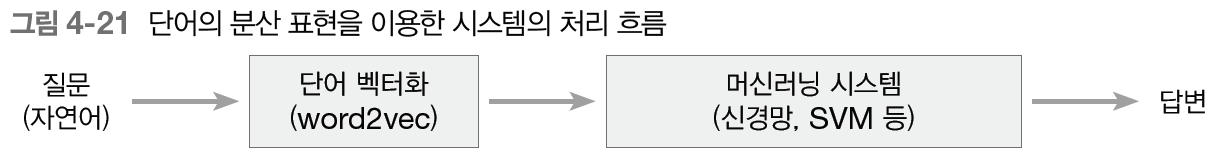

In [34]:
Image.open(os.path.join(img_path, 'fig 4-21.png'))

그림에서 보듯 자연어로 쓰여진 질문을 고정 길이 벡터로 변환할 수 있다면, 그 벡터를 머신러닝 모델의 입력으로 사용가능하며, 머신러닝 모델의 틀에서 원하는 답을 출력하는 것이 가능해진다.

메일을 자동으로 분류하는 시스템을 만드는 문제를 생각해본다.

[그림 4-22]처럼 메일의 내용을 보고 사용자의 감정을 3단계로 분류할 수는 없는지 고민한다.

사용자의 감정을 정확하게 분류할 수 있다면, 불만을 가진 사용자의 메일부터 순서대로 살펴볼 수 있게 된다.

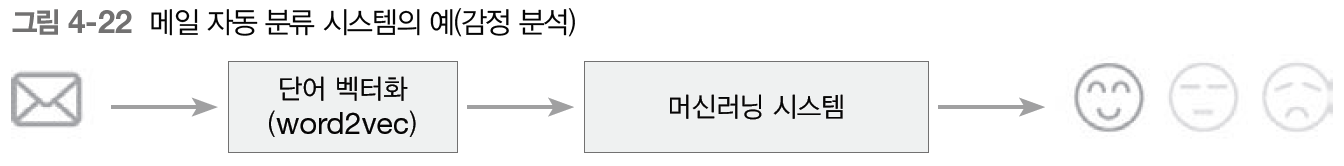

In [36]:
Image.open(os.path.join(img_path, 'fig 4-22.png'))

메일 자동 분류 시스템을 만들려면,

1. 데이터(메일) 수집 : 사용자가 보낸 메일을 모으고, 메일들에 수동으로 감정 레이블링(긍정적, 중립적, 부정적)
2. 벡터 변환 : 레이블링 작업이 끝나면 학습된 word2vec을 이용해 메일을 벡터로 변환
3. 분류 시스템 : 감정 분석을 수행하는 분류 시스템(SVM이나 신경망 등)에 벡터화된 메일과 감정 레이블을 입력하여 학습 수행

이와 같이 자연어를 다루는 문제는 단어의 분산 표현이라는 방법으로 벡터화할 수 있다.

그 덕분에 일반적인 머신러닝 기법으로도 문제를 해결할 수 있게 된다. 게다가 word2vec 전이 학습의 혜택도 누릴 수 있다.

즉, 다양한 자연어 처리 문제에서 word2vec으로 구축한 단어의 분산 표현을 이용함으로써 정확도를 높일 수 있다.

### 4.4.2 단어 벡터 평가 방법

word2vec을 통해 단어의 분산 표현을 얻을 수 있었다.

그럼 그 분산 표현이 좋은지는 어떻게 평가할까?

단어의 분산 표현은 앞 절에서 본 감정 분석 예처럼, 현실적으로는 특정한 어플리케이션에서 사용되는 것이 대부분이다.

그렇다면 우리가 궁극적으로 원하는 것은 정확도 높은 시스템이 된다.

여기서 생각해야 하는 것은 그 시스템(예컨대 감정 분석 시스템)은 여러 시스템으로 구성된다는 것이다.

여러 시스템이란, 앞선 예로 말하면 단어의 분산 표현을 만드는 시스템(word2vec)과

특정 문제에 대해 분류를 수행하는 시스템(예컨대 감정을 분류하는 SVM 등)이다.

단어의 분산 표현을 만드는 시스템과 분류하는 시스템의 학습은 따로 수행할 수도 있다.

이 경우, 예컨대 단어의 분산 표현의 차원 수가 최종 정확도에 어떤 영향을 주는지를 조사하려면,

우선 단어의 분산 표현을 학습하고, 그 분산 표현을 사용하여 또 하나의 머신러닝 시스템을 학습시켜야 한다.

즉, 두 단계의 학습을 수행한 다음 평가해야 한다. 또한, 이 경우 두 시스템 각각에서 최적의 하이퍼파라미터를 찾기 위한 튜닝도 필요하므로, 그만큼 오랜 시간이 걸리게 된다.

그래서 단어의 분산 표현의 우수성을 실제 어플리케이션과는 분리해 평가하는 것이 일반적이다.

이때 자주 사용되는 평가 척도가 단어의 '유사성'이나 '유추 문제'를 활용한 평가이다.

1. $\textbf{단어의 유사성 평가}$

주로 사람이 작성한 단어 유사도를 검증 세트를 사용해 평가하는 것이 일반적이다.

예를 들어 유사도를 0에서 10 사이로 점수화한다면 "cat"과 "animal"의 유사도는 8점, 

"cat"과 "car"의 유사도는 2점처럼, 사람이 단어 사이의 유사한 정도를 규정한다.

그리고 사람이 부여한 점수와 word2vec에 의한 코사인 유사도 점수를 비교해서 그 상관성을 보는 것이다.

2. $\textbf{유추 문제를 활용한 평가}$

"king : queen = man : ?"과 같은 유추 문제를 출제하고, 그 정답률로 단어의 분산 표현의 우수성을 측정한다.

[그림4-23]은 유추 문제에 의한 평가 결과일부를 논문[27]에서 발췌한 것이다.


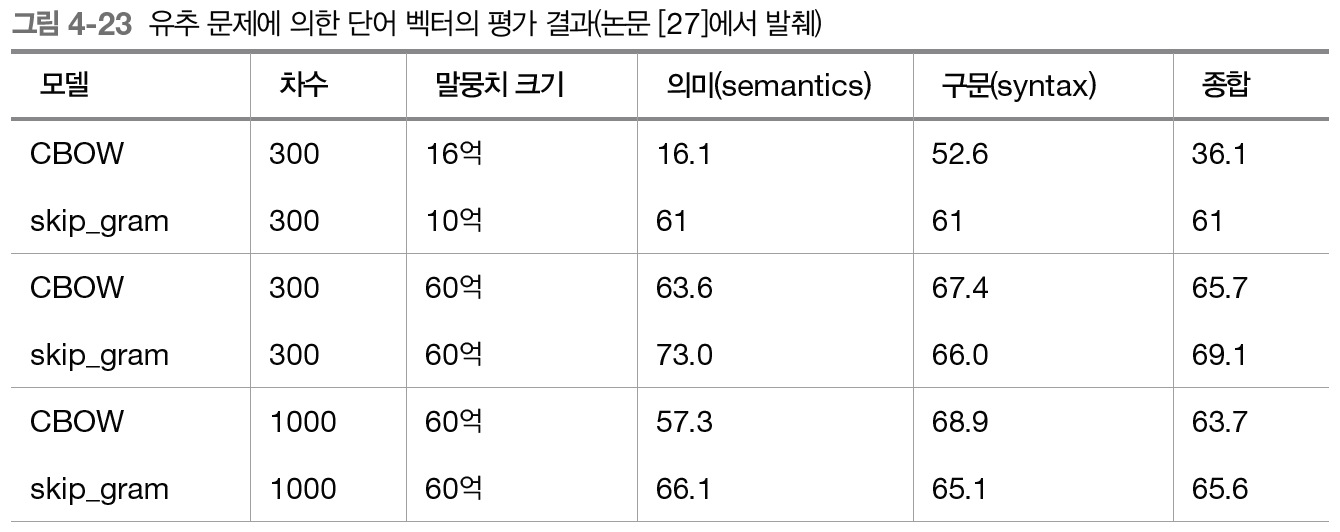

In [37]:
Image.open(os.path.join(img_path, 'fig 4-23.png'))

표의 '의미'열은 단어의 의미를 유추하는 유추 문제의 정답률을 보여준다. "king : queen = actor : actress" 와 같은 문제이다.

'구문'열은 단어의 형태 정보를 묻는 문제로, "bad : worst = good : best"같은 문제를 말한다.

$\textbf{NOTE}$

[그림 4-23]의 결과로부터 다음을 알 수 있다.

- 모델에 따라 정확도가 다르다(말뭉치에 따라 적합한 모델 선택).
- 일반적으로 말뭉치가 클수록 결과가 좋다(항상 데이터가 많은 게 좋음).
- 단어 벡터 차원 수는 적당한 크기가 좋다(너무 커도 정확도가 나빠짐).

유추 문제를 이용하면 '단어의 의미나 문법적인 문제를 제대로 이해하고 있는지'를 (어느 정도) 측정할 수 있다.

그러므로 유추 문제를 정확하게 풀 수 있는 단어의 분산 표현이라면 자연어를 다루는 어플리케이션에서도 좋은 결과를 기대해 볼 수 있다.

그러나 단어의 분산 표현의 우수함이 어플리케이션에 기여하는 비율은 어플리케이션 종류나 말뭉치의 내용 등, 다루는 문제 상황에 따라 달라진다.

즉, 유추 문제에 의한 평가가 높다고 해서 어플리케이션에서도 반드시 좋은 결과가 나오리라는 보장은 없다는 것이다.

## 4.5 정리

$\textbf{이번 장에서 배운 내용}$
- Embedding 계층은 단어의 분산 표현을 담고 있으며, 순전파 시 지정한 단어 ID의 벡터를 추출한다.
- word2vec은 어휘 수의 증가에 비례해서 계산량도 증가하므로, 근사치로 계산하는 빠른 기법을 사용하는 게 좋다.
- 네거티브 샘플링은 부정적 예를 몇 개 샘플링하는 기법으로, 이를 이용하면 다중 분류를 이진 분류처럼 취급할 수 있다.
- word2vec으로 얻은 단어의 분산 표현에는 단어의 의미가 녹아들어 있으며, 비슷한 맥락에서 사용되는 단어는 단어 벡터 공간에서 가까이 위치한다.
- word2vec의 단어의 분산 표현을 이용하면 유추 문제를 벡터의 덧셈과 뺄셈으로 풀 수 있게 된다.
- word2vec은 전이 학습 측면에서 특히 중요하며, 그 단어의 분산 표현은 다양한 자연어 처리 작업에 이용할 수 있다.